In [95]:
%matplotlib inline  
import numpy as np
from matplotlib import pyplot as plt
import string
import math

#Optimizing sklearn speed.
from sklearnex import patch_sklearn 
patch_sklearn()
'''
If you do not want this enabled, simply remove the two lines above. I am unsure if the models that utilize this module
Is compatible if it is disabled, hence I have trained the basic and final SVC models with and without. Incase you would use on over the other. 
'''



from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import feature_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

import time

#For saving heavy models. Searialize and deserialize a python structure
import pickle

seed = 42

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [96]:
X = np.load("emnist_hex_images.npy")
y = np.load("emnist_hex_labels.npy")

In [97]:
X.shape

(107802, 400)

107802 data points, with 400 features. I.e 107802 pictures that are of dimension 20x20

In [98]:
y.shape

(107802,)

### How is the data distributed?

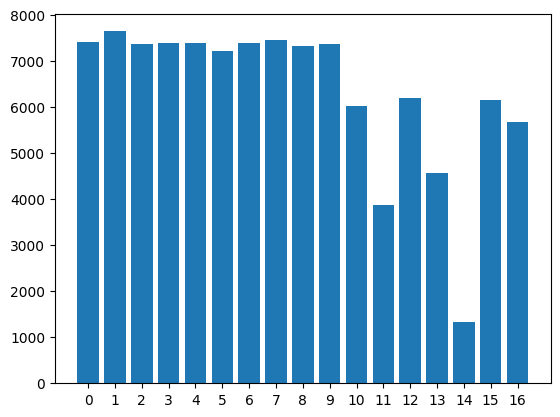

In [99]:
def label_distribution(y):
    labels, counts = np.unique(y, return_counts=True)
    plt.bar(labels,counts)
    plt.xticks(np.arange(0,17))
    plt.show

label_distribution(y)



We can see that classes imbalanced. There are similar representation of digits. However there are fewer letters, and especially label 14, class E has very few samples

#### What can we do with the inbalance?
We could downsample some of the digits.
- Pros
  - More equal representation
  - Smaller dataset, so easier to train.
- Cons
  - Can lose important information. 

We could upsample some of the letters.
- Pros
  - More equal representation
- Cons
  - Dataset becomes larger

Our dataset is large, so we could use a combination of downsampling and upsampling. \
\
Maybe the unbalance is a result of the production. I.e. gift of class E is more time consuming to produce. Or the most logical reason is that gifts of class empty, should have class e or class of the other letters.  \
\
Im going to upsample to majority class, then downsample the entire dataset to its original lenght

In [100]:
#How many samples should be per class
n_data_samples = math.floor(X.shape[0]/17)
n_data_samples

6341

In [101]:
y_digits = np.where((y == 0) | (y == 1) | (y == 2) | (y == 3) | (y == 4) | (y == 5) | (y == 6) | (y == 7) | (y == 8) | (y == 9))

In [102]:
y_letters = np.where((y == 10) | (y == 11) | (y == 12) | (y == 13) | (y == 14) | (y == 15) | (y == 16))

In [103]:
np.unique(y[y_digits]), np.unique(y[y_letters])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([10, 11, 12, 13, 14, 15, 16], dtype=uint8))

In [104]:
def downsample(start, end):
    X_digits_downsampled = np.empty((0,400))
    y_digits_downsampled = np.empty(0)
    for x in range(start,end):
        maj_class = np.where(y==x)
        x_resampled, y_resampled = resample(X[maj_class], y[maj_class], replace=False, n_samples = n_data_samples, random_state=seed)
        X_digits_downsampled = np.concatenate([X_digits_downsampled, x_resampled])
        y_digits_downsampled = np.append(y_digits_downsampled, y_resampled)
    
    return X_digits_downsampled, y_digits_downsampled

In [105]:
def upsample(start, end):
    X_digits_downsampled = np.empty((0,400))
    y_digits_downsampled = np.empty(0)
    for x in range(start,end):
        maj_class = np.where(y==x)
        x_resampled, y_resampled = resample(X[maj_class], y[maj_class], replace=True, n_samples = n_data_samples, random_state=seed)
        X_digits_downsampled = np.concatenate([X_digits_downsampled, x_resampled])
        y_digits_downsampled = np.append(y_digits_downsampled, y_resampled)
    
    return X_digits_downsampled, y_digits_downsampled

In [106]:
X_digits_downsampled, y_digits_downsampled = downsample(0,10)
X_digits_downsampled.shape

(63410, 400)

In [107]:
X_digits_upsampled, y_digits_upsampled = upsample(10,17)
X_digits_upsampled.shape

(44387, 400)

(107797, 400) (107797,)


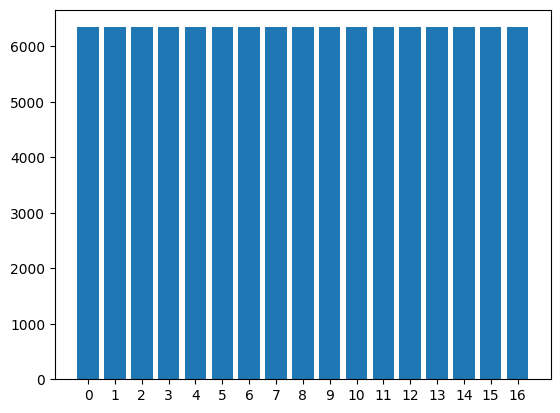

In [108]:
X_balanced = np.concatenate([X_digits_downsampled, X_digits_upsampled])
y_balanced = np.append(y_digits_downsampled, y_digits_upsampled)
X_balanced = np.array(X_balanced, dtype=np.uint8)
y_balanced = np.array(y_balanced, dtype=np.uint8)
print(X_balanced.shape, y_balanced.shape)
label_distribution(y_balanced)

In [109]:
y_balanced,X_balanced, X, y

(array([ 0,  0,  0, ..., 16, 16, 16], dtype=uint8),
 array([[13, 85, 68, ..., 58, 20,  0],
        [60, 32, 22, ...,  0, 33, 10],
        [25,  0, 46, ...,  5, 14, 45],
        ...,
        [42, 10,  0, ..., 10,  3, 10],
        [55,  0, 26, ..., 24, 64, 72],
        [10, 16, 53, ...,  0, 13, 35]], dtype=uint8),
 array([[43,  0, 51, ...,  0,  5,  0],
        [32, 29,  0, ...,  0,  0, 69],
        [61,  0, 15, ...,  0, 28,  1],
        ...,
        [29, 22, 24, ...,  0,  6,  0],
        [33, 40, 25, ...,  0, 27, 17],
        [20,  0, 14, ..., 33, 53, 36]], dtype=uint8),
 array([ 9,  9, 12, ..., 13,  7,  1], dtype=uint8))

In [110]:
#When downsampling replace is false

X_majority_downsample, y_majority_downsample = resample(X[y_digits], y[y_digits], replace=False, n_samples = n_data_samples*10, random_state=seed)

#Cannot get them to be totaly equally distributed with stratify argument.
X_majority_downsample.shape, np.unique(y_majority_downsample, return_counts=True)

((63410, 400),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([6341, 6593, 6261, 6325, 6322, 6193, 6378, 6409, 6271, 6317],
        dtype=int64)))

In [111]:
#When downsampling replace is false
X_minority_upsample, y_minority_upsample = resample(X[y_letters], y[y_letters], replace=True, n_samples = n_data_samples*5, random_state=seed)
X_minority_upsample.shape, np.unique(y_minority_upsample, return_counts=True)

((31705, 400),
 (array([10, 11, 12, 13, 14, 15, 16], dtype=uint8),
  array([5659, 3551, 5865, 4280, 1256, 5780, 5314], dtype=int64)))

In [112]:
def show_img(arr,cmap='Greys',figsize=(1,1)):
    plt.figure(figsize=figsize)
    plt.imshow(arr.reshape(20,20), vmin=0, vmax=255, cmap=cmap)
    plt.axis('off')
    plt.show()

In [113]:
#Writing a small function that displays the image array as an image with matplotlib. 
def show_n_images(n, rows=1):

    fig = plt.figure(figsize=(20,20))
    rows = rows
    columns = int(n/rows)
    
    for ind in range(0,n):
        fig.add_subplot(rows, columns, ind+1)
        plt.imshow(X[ind].reshape(20,20), vmin=0, vmax=255, cmap='Greys') #Grey looks feels more clear than binary colormap.
        plt.axis('off')

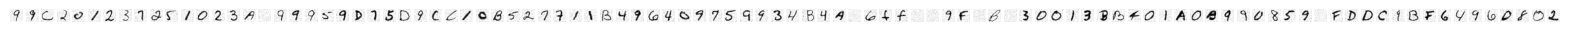

In [114]:
show_n_images(100)

In [115]:
y[0:100]

array([ 9,  9, 12,  2,  0,  1,  2,  3,  7,  2,  5,  1,  0,  2,  3, 10, 16,
        9,  9,  9,  5,  9, 13,  7,  5, 13,  9, 12, 12,  1,  0, 11,  5,  2,
        7,  7,  1,  1, 11,  4,  9,  6,  4,  0,  9,  7,  5,  9,  9,  3,  4,
       11,  4, 10, 16,  6, 15, 15, 16, 16,  9, 15, 16, 11, 16,  3,  0,  0,
        1,  3, 11, 11,  4,  0,  1, 10,  0, 11,  9,  9,  0,  8,  5,  9, 16,
       15, 13, 13, 12,  9, 11, 15,  6,  4,  9,  6,  0,  8,  0,  2],
      dtype=uint8)

In [116]:
y[16]

16

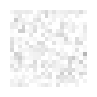

In [117]:
show_img(X[16])

Can see that pictures that is labeled 16 is empty.

### Creating a hashmap/dictionary with class and label

In [118]:
digits = [str(num) for num in range(0,10)]
letters = [char for char in string.ascii_uppercase[:6]]
classes = digits + letters + ['empty']
hex_label = {key:value for value, key in enumerate(classes)}
label_hex = {key:value for key, value in enumerate(classes)}
hex_label, label_hex

({'0': 0,
  '1': 1,
  '2': 2,
  '3': 3,
  '4': 4,
  '5': 5,
  '6': 6,
  '7': 7,
  '8': 8,
  '9': 9,
  'A': 10,
  'B': 11,
  'C': 12,
  'D': 13,
  'E': 14,
  'F': 15,
  'empty': 16},
 {0: '0',
  1: '1',
  2: '2',
  3: '3',
  4: '4',
  5: '5',
  6: '6',
  7: '7',
  8: '8',
  9: '9',
  10: 'A',
  11: 'B',
  12: 'C',
  13: 'D',
  14: 'E',
  15: 'F',
  16: 'empty'})

Displaying all the empty images in the first 100 images

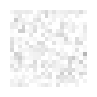

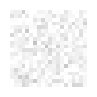

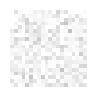

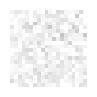

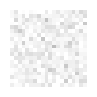

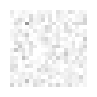

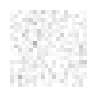

In [119]:
def display_label_n(label, n):
    label = hex_label[label]
    points = X[:n][y[:n] == label]
    
    for x in points:
        show_img(x)

display_label_n('empty',100)

In [120]:
label_16 = X[y == 16]
len(label_16), round(len(label_16)/y.shape[0], 5)

(5678, 0.05267)

Safe to say that when the picture is empty, the label will be 16. So when the model predicts 16, we know that an elf has forgotten to label properly, so the CEO would be notified. Around 5.3% of the images are empty

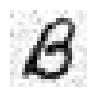

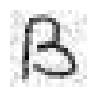

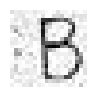

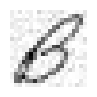

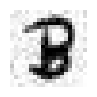

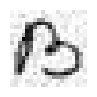

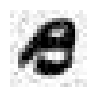

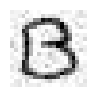

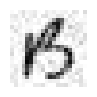

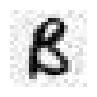

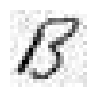

In [121]:
#Looking at the images that should be marked as b, in the first 200 images
display_label_n('B',200) #display_label_n('8',200)
#Based on pictures of b and 8, there are some b's that looks like 8's. Maybe that would confuse the model. 

### Thoughts about the data

Our data is <b>labled</b>, so it is suitable to train <b>supervised models</b>. There are many samples, and <b>good distribuition</b> between different classes. The data has <b>high dimensionality</b>. 

### Deciding how good a model performs. I.e choosing performance measure/metric

There are multiple ways to decide how good a classifier is, and depends on the circumstance. \
\
For instance if right is right, and wrong is wrong, then he accuracy(right/all) is a good metric to evaluate performance. \
\
If there were the case that some false positive/negative are more detremental than others, or the distribution is uneven, then precision and recall could be used together to get a F1 score. Precision is important when false positive is costly, and recall is important when false negative is costly. The F1 score works well with inbalanced or skewed dataset, where the distribution is not equal or close to equal. It gives a measure \
\
We should take a step back to analyse the description of the task. We know that the classes on the presents represent what type of gift it is. Our model would indicate where the gift should be distributed to.\
\
*Choice of f1 average - fictive scenario*\
If the distribution of gifts are based on how much they produced in a period of time, then the class with low numbers took a long time to make. I would assume that santa has made a quota of how many of each gift should be made. If a time consuming gift is misclassified as a quick gift, then production would continue for the time consuming gift. We can make this more noticible if we use the macro average, as it punishes unweighted. If the imbalance is pure coincidence, then the using wighted average is better. This is all reflection and speculation, so I assume both averages would be presentable. \
\
We do however know that some gifts are less represented in our data, i.e. our data is skewed/imbalanced. Thus F1 with weighted average could be a valid if some gifts really are not as important as others. However if we want each gift to be treated as equal, then taking the macro average would be the best. I would treat all gifts as equal. F1 does not say which classes to be vary of, hence a confision matrix would also be a good metric to see patterns in our results. Like if o and 0 are confused. Overall accuracy is genreally nice to know too, and the data does not appear to be dramatically distributed towards one specific class. F1 score appears to be the safest. \
\
<b>Conclusion:</b> I am going to use primarily F1 score with macro average. Then confusion matrix and accuracy to understand the results.

### Splitting data into train and test

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, shuffle=True, random_state=seed, stratify=y_balanced)
#The stratify argument, asures balanced dataset based on labels. So instead of being super unlucky and having all labels 16 in train for example. 

In [123]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((86237, 400), (86237,)), ((21560, 400), (21560,)))

In [124]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=seed)#, stratify=y_test)

In [125]:
(X_test.shape, X_val.shape), (X_test.shape, y_test.shape)

(((10780, 400), (10780, 400)), ((10780, 400), (10780,)))

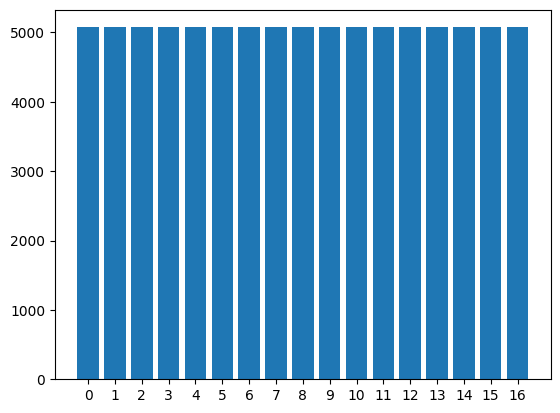

In [126]:
#Showing distribution of y_train
label_distribution(y_train)

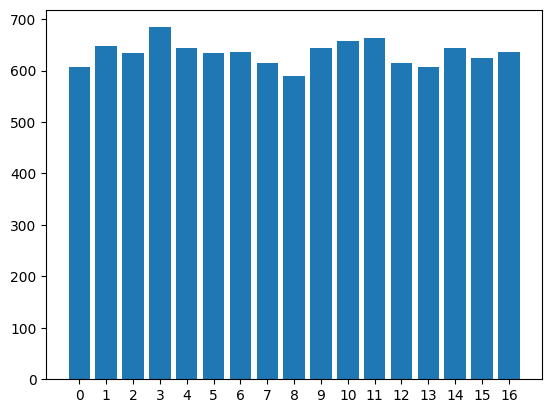

In [127]:
label_distribution(y_val)

Stratify makes the distribution similar in the split. This could in theory cause a 'imformation leak', but it is very unlikely. Stratify itself is ment to give a accurate distribution of the population to the training. The test set could be stratified or non stratified, and that would not change how the model is already trained. It is true that we then know the distribution of y_test, but we do not know how X_test is structured. 

In [128]:
#print('Training')
#print_label_distribution(y_train)
#print('\n Test')
#print_label_distribution(y_test)


# Testing some classifiers

I will test the following classifiers

- Traditional ML - Good for structured
  - Support vector machine
  - K-nearest neighbor
  - Decision trees
    - Random forest
    - Gradient boosted machine
- Deep learning - Good for unstructured too, but takes longer then ml on structured. GPU makes it faster.
  - Artificial neural network 

Generally, images are classified as unstructured data. The image data we are working with have been structured, value for each pixel, that is workable for the machine learning models and deep learning. It would be interesting to see if the performance are different. 

## Testing with SVM
### Why?

Our data is labled, so a supervised model is good. It can do classification, regression and outliers detection. There will be some outliers, because the elves have different handwriting. Some writes nice and clear, whilst other scribles. And the main point is that SVMs are good dealing with <b>high dimensional spaces</b>

In [48]:
#Creating a default SVC classifier
def train_svc():
    print('Starting training')
    start = time.time()
    default_SVC_clf = SVC()
    default_SVC_clf.fit(X_train, y_train)
    end = time.time()
    print(f'Finished training, total time elapsed: {end-start} s')
    return default_SVC_clf


In [45]:
#Testing the time of how long it takes to train

Without intelx\
Starting training\
Finished training, total time elapsed: 308.5273628234863 s \
\
With intelx\
Starting training\
Finished training, total time elapsed: 43.453662633895874 s \
\
This is because it uses more of the cpu

In [46]:
#If it is needed to see that they perform identical

Loaded_svc_model_2 = pickle.load(open('models/SVMs/default_svc_2', 'rb'))
Loaded_svc_model_1 = pickle.load(open('models/SVMs/default_svc_1', 'rb'))

predictions_test_1 = Loaded_svc_model_1.predict(X_test)
predictions_test_2 = Loaded_svc_model_2.predict(X_test)

metrics.accuracy_score(y_test, predictions_test_1),metrics.accuracy_score(y_test, predictions_test_2)

''

(0.9641482306015491, 0.9641482306015491)

##### Doing some tests with the classifier
The default params are gamma='scale' and C=1.\
Scale is 1 / (n_features * X.var()) \
\
Doing some small tests before using grid test to find the best model. Because doing a grid test would be very computational.

In [169]:
def test_svc(X,y, X_val, y_val, gamma='scale', C=1, kernel='rbf', msg=''):
    #Initializing the classifier and training.
    start_train = time.time()
    
    SVC_clf = SVC(gamma=gamma, C=C, kernel=kernel, cache_size=2000)
    SVC_clf.fit(X, y)
    
    end_train = time.time()
    train_time = end_train-start_train

    #Making predictions and valuating.
    start_val = time.time()
    
    val_pred = SVC_clf.predict(X_val)
    val_accuracy = metrics.accuracy_score(y_val, val_pred)
    print('Val accuracy of the model:', val_accuracy)
    
    train_pred = SVC_clf.predict(X)
    train_accuracy = metrics.accuracy_score(y, train_pred)
    print('Train accuracy of the model:', train_accuracy)
    
    val_f1 = metrics.f1_score(y_val, val_pred, average='macro')
    print('f1 score of the model:', val_f1)

    end_val = time.time()
    val_time = end_val-start_val

    #Save the models and document stats
    #pickle.dump(SVC_clf, open(f'models/SVMs/parameter_tests/svc_rbf_model_g{gamma}_C{C}', 'wb'))
    #Some of the models became up to 5gb.
    
    with open('models/SVMs/parameter_tests/model_stats.txt', 'a') as stats:
        stats.write(f'rbf_g{gamma}_C{C} | Train: {train_time:.3f}, Val: {val_time:.3f}, G: {gamma}, C: {C}, \Accuracy: {val_accuracy:.5f} | msg:{msg}\n')
    
    print('Elapsed', train_time+val_time, 'seconds')

    return val_f1

    
    

In [170]:
test_svc(X_train,y_train, X_val, y_val)

Val accuracy of the model: 0.9755102040816327
Train accuracy of the model: 0.9873488177928268
f1 score of the model: 0.9753159608427031
Elapsed 80.87807822227478 seconds


0.9753159608427031

<function matplotlib.pyplot.show(close=None, block=None)>

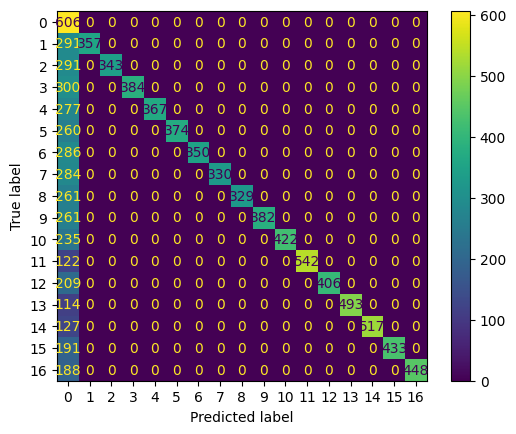

In [140]:

Loaded_rf_model = pickle.load(open('models/SVMs/parameter_tests/svc_rbf_model_g1_C1', 'rb'))
underfit_pred = Loaded_rf_model.predict(X_val)
rf_matrix = metrics.confusion_matrix(y_val, underfit_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=Loaded_rf_model.classes_)
disp.plot()

plt.show


By looking at the results of some small testing, we see that gamma has to be very small because of the high dimensionality and variance. Else it takes a long time to compute, that makes sense since higher gamma gives a more complex decision bondary.\

Many of the characters are similar, so perhaps it guesses one character more than others. We also see that increasing C gives higher accuracy. So it would be more beneficial to train with low gamma, and high C. 

### Training is expensive and slow

#### Why is it slow?

We know that distance between each points has to be computed to decide where the decision boundary is placed. The formula for calculating the distance takes <b>O(m * n^2)</b>, where <b>m</b> is number of features and <b>n</b> is samples. Storing all the distances takes much memory, so it is computed each time, except for frequent distances are kept in a cache. This also gives reason for why the models became very large.

#### What can we do?

There are many samples, and they have large dimensionality. So we can do something about sample size or the feature size. \
The formula for 
\
<b>Sample size</b>
- Simply train with less data.
- Pros
  - Faster
- Cons
  - Less accurate
 
<b>Scale samples</b>
- Instead of computing large values, it can rather compute with scaled values.

<b>Feature size:</b>
- Not all the pixels are as relevant as the others. 
- Feature selection: https://scikit-learn.org/stable/modules/feature_selection.html
  - Chose relevant features, and exclude the rest.
- Feature reduction
  - Reduce dimentionality by column reduction. 
  - Goal is to reduce the number of unimportant features. In this case the corner pixels would very likely be unimportant for classification.
  - Pros
    - Faster to compute
    - Can remove outliers
  - Cons
    - May reduce important information

\
I want to keep the amount of training samples, so I will test dimensionality reduction\
To get a better intuition of what features might get removed, I will draw a heatmap of mean values for each pixel.




In [171]:
#Creating a scaler to change value from int in range 0,255 to a scaled value.
scal = preprocessing.MinMaxScaler()
scal.fit(X_train)
X_train_scaled = scal.transform(X_train)
X_val_scaled = scal.transform(X_val)

print(f'Scaled |Var, std, mean - {X_train_scaled.var(), X_train_scaled.std(), X_train_scaled.mean()}\n')
print(f'Non    |Var, std, mean - {X_train.var(), X_train.std(), X_train.mean()}\n')

#Testing the speed and accuracy
print('scaled')
test_svc(X_train_scaled[:20000], y_train[:20000], X_val_scaled, y_val, msg='scaled data')

print('\nnon-scaled')
test_svc(X_train[:20000], y_train[:20000], X_val, y_val, msg='not scaled')

#Results shows that in this case, scaling gets worse performance and accuracy. 
#The benefit however is that the variance is low, so gamma is less sensitive and easier to work with. 

Scaled |Var, std, mean - (0.07729617562801745, 0.27802189774911157, 0.2552930300086888)

Non    |Var, std, mean - (5008.542503712599, 70.77105696337027, 59.12596968238691)

scaled
Val accuracy of the model: 0.9521335807050093
Train accuracy of the model: 0.9858
f1 score of the model: 0.951959003613456
Elapsed 16.777629137039185 seconds

non-scaled
Val accuracy of the model: 0.9535250463821893
Train accuracy of the model: 0.9822
f1 score of the model: 0.953337456100048
Elapsed 16.157782316207886 seconds


0.953337456100048

#### Reducing features

In [130]:
heat_pixel_map = np.array([X[:,ind].mean() for ind in range(X.shape[1])])

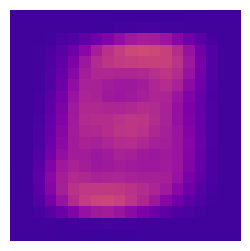

In [131]:
show_img(heat_pixel_map.reshape(20,20), figsize=(3,3), cmap='plasma')

In [132]:
def reduce_map(map, value=heat_pixel_map.mean(), padding=0):
    map_temp = np.copy(map)
    map_temp[map_temp<(value-padding)] = 0
    return map_temp

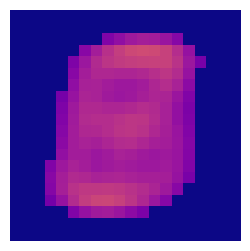

Number of relecant pixels = 179


In [133]:
reduced_map = reduce_map(heat_pixel_map)
show_img(reduced_map.reshape(20,20), figsize=(3,3), cmap='plasma')
print(f'Number of relecant pixels = {len(np.nonzero(reduced_map)[0])}')

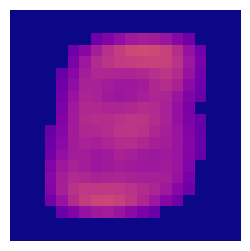

Number of relecant pixels = 199


In [134]:
reduced_map = reduce_map(heat_pixel_map, padding=10)
show_img(reduced_map.reshape(20,20), figsize=(3,3), cmap='plasma')
print(f'Number of relecant pixels = {len(np.nonzero(reduced_map)[0])}')

In [135]:
def reduce_mean(arr, map):
    np.asarray(map==0).nonzero()[0]
    return np.delete(arr, np.asarray(map==0).nonzero()[0], axis=1)

In [172]:
reduced_map = reduce_map(heat_pixel_map, padding=10)
reduced_X_train = reduce_mean(X_train, reduced_map)
reduced_X_val = reduce_mean(X_val, reduced_map)
test_svc(reduced_X_train[:20000], y_train[:20000], reduced_X_val, y_val, msg='mean reduced features')

Val accuracy of the model: 0.9553803339517625
Train accuracy of the model: 0.9834
f1 score of the model: 0.9551850567439184
Elapsed 12.094642877578735 seconds


0.9551850567439184

#### Decide based on variance

In [173]:
selection = feature_selection.VarianceThreshold(X_train.var()*0.8)
selection.fit(X_train)
X_train_reduced = selection.transform(X_train)
X_val_reduced = selection.transform(X_val)
X_train_reduced.shape, X_val_reduced.shape

((86237, 191), (10780, 191))

In [174]:
test_svc(X_train_reduced[:20000], y_train[:20000], X_val_reduced, y_val, msg=' data')

Val accuracy of the model: 0.9544526901669759
Train accuracy of the model: 0.98305
f1 score of the model: 0.9541811152446454
Elapsed 11.132175207138062 seconds


0.9541811152446454

#### Univariate

That is faster, but lets say we want to have the 50 best features instead

In [175]:
model = feature_selection.SelectKBest(feature_selection.chi2,k=50).fit(X_train, y_train)
X_train_reduced = model.transform(X_train)
X_val_reduced = model.transform(X_val)
test_svc(X_train_reduced[:20000], y_train[:20000], X_val_reduced, y_val, msg='mean reduced features')

Val accuracy of the model: 0.8358070500927643
Train accuracy of the model: 0.87805
f1 score of the model: 0.8353261738031522
Elapsed 7.836537837982178 seconds


0.8353261738031522

This did not give the preffered results. This is because we are removing information, and if we remove too much then relations in the data will be gone. Maybe if we could represent our data more compact. I.e, maybe we can just represent it differently like a projection. 

### Testing with pca 

Finds the most relevant features for variance. Instead of removing the features, that removes information, you project the data to a space that represents the most relevant of the data. It is very useful, as you can specify the number of components you want. In-short, reduce the dimension drastically representing the data as projections, while keeping much relevant information. \
https://scikit-learn.org/stable/modules/decomposition.html#pca

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Tested with whiten=True, but did not get better results contrary to stated in the doc. This makes sense, because it can improve predictive accuracy by making data respect some "hard-wired" assumptions. It would make sense here, since we should classify digits, but not everyone has identical handwriting. And by looking at some of the pictures and lables, some of the pictures are on the borderline to classify as their respective label. So the assumptions would backfire, and disqualify the outliers. 

Small accuracy increase and minimal performance cost, when enabling svd_solver to full. It should be activated when using default 'auto', unless you are decreasing dimension under a set threshold. The reduction was most likely under the threshold, so it used svd_solver='random' first. 

#### How to find the best number of dimensions?

pca tries to explain the data with variance with primary components. They tell how important a feature is. The components have a hierarchy of explainability. The ones with the highest explainability are the most important. We can see how much explainability we gain with increasing the number of dimensions, which increases the number of components

In [176]:
def test_pca(n):
    pca_test = decomposition.PCA(n_components=n, random_state=seed, svd_solver = 'full')
    pca_test.fit(X_train)
    return pca_test.explained_variance_ratio_.sum()


In [177]:
def variance_pca(n_dim,step_size, start=0):
    explain_rate = []
    n_dims = []
    for i in range(start,n_dim+start,step_size):
        explain_rate.append(test_pca(i))
        n_dims.append(i)

    plt.plot(n_dims, explain_rate, label='explained variance')

    plt.xlabel('number of dimensions')  
    plt.ylabel('Explained variance percent') 
      
    # giving a title to my graph 
    plt.title(f'Explained variance based on interval of dimensions: {start} to {n_dim+start}') 
    plt.legend() 
    
    
    plt.show()
        


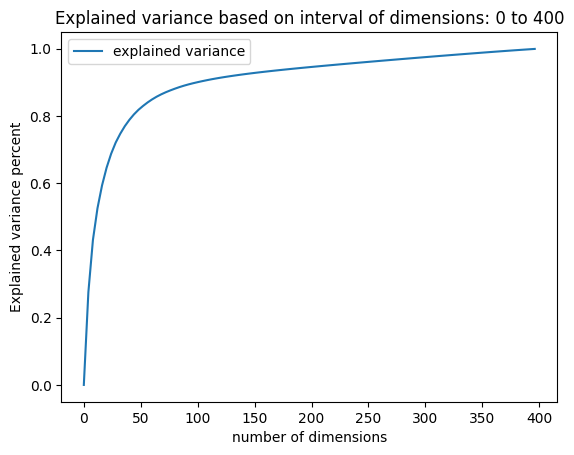

In [444]:
variance_pca(400, 4)

By eyeballing the curve, it looks like number of dimensions around 50 is optimal for accuracy and speed. 

#### Now reducing the data with 50 components

In [178]:
#Creating the analyser 
pca = decomposition.PCA(n_components=50, random_state=seed, svd_solver = 'full')

#Fitting it to the training data
pca.fit(X_train)

#Transforming the datasets
pca_X_train = pca.transform(X_train)
pca_X_val = pca.transform(X_val)
pca_X_test = pca.transform(X_test)

#Incase scaled data would be prefered. But it takes longer to train and predict.

scal = preprocessing.StandardScaler()
scal.fit(pca_X_train)
pca_X_train_scaled = scal.transform(pca_X_train)
pca_X_val_scaled = scal.transform(pca_X_val)
pca_X_test_scaled = scal.transform(pca_X_test)


In [181]:
#Running a small test with the reduced data
print('pca reduced')
test_svc(pca_X_train[:20000], y_train[:20000], pca_X_val, y_val, msg='pca reduced data')
print('\npca reduced and scaled')
test_svc(pca_X_train_scaled[:20000], y_train[:20000], pca_X_val_scaled, y_val, msg='scaled pca reduced data')


pca reduced
Val accuracy of the model: 0.9592764378478664
Train accuracy of the model: 0.98175
f1 score of the model: 0.9590636923826293
Elapsed 7.110773086547852 seconds

pca reduced and scaled
Val accuracy of the model: 0.9571428571428572
Train accuracy of the model: 0.98815
f1 score of the model: 0.956895819509392
Elapsed 8.810810804367065 seconds


0.956895819509392

Scaled worked better, but it takes longer to train. I will performance with scaled, but not run the grid search with it. \
Now showing what pixels are relevant based on the primary components

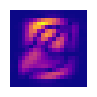

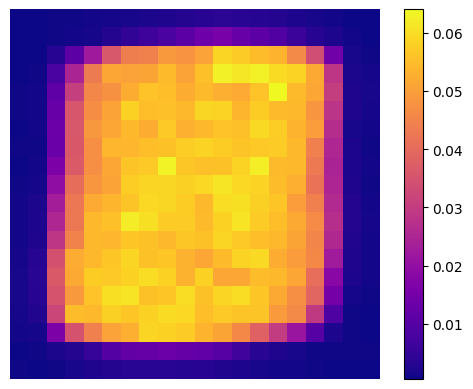

In [159]:
#feature_importance_first_pc
def show_pca(n_pc):
    fifpc = abs(pca.components_)[n_pc]
    plt.figure(figsize=(1,1))
    plt.imshow(fifpc.reshape(20,20), vmin=fifpc.min(), vmax=fifpc.max(), cmap='plasma') 
    plt.axis('off')
    plt.show()

show_pca(2)


average_pixel_importance = abs(pca.components_).mean(axis=0)
plt.imshow(average_pixel_importance.reshape(20,20), vmin=average_pixel_importance.min(), vmax=average_pixel_importance.max(),cmap='plasma')
plt.colorbar()
plt.axis('off')
plt.show()


Here we can see what pixels become most important when the dimension is 50 with pca

These results are very exiting. This means that we can train the model very fast. That is important for running grid search with different parameters. Since gridsearch also does crossvalidation, so it is (param*param*...*param)*5 

### Small test with hyperparameters with smaller sample

To see what direction and intervall is the most logical for the bigger tests


In [182]:
#Testing different gamma values
print('Scale')
test_svc(pca_X_train[:10000], y_train[:10000], pca_X_val, y_val, gamma='scale', msg='pca reduced data')
print('auto')
test_svc(pca_X_train[:10000], y_train[:10000], pca_X_val, y_val, gamma='auto', msg='pca reduced data')
print('0.001')
test_svc(pca_X_train[:10000], y_train[:10000], pca_X_val, y_val, gamma=0.001, msg='pca reduced data')


Scale
Val accuracy of the model: 0.94860853432282
Train accuracy of the model: 0.9799
f1 score of the model: 0.9483824306928701
Elapsed 2.1892197132110596 seconds
auto
Val accuracy of the model: 0.11827458256029684
Train accuracy of the model: 1.0
f1 score of the model: 0.1059214932220327
Elapsed 3.694380760192871 seconds
0.001
Val accuracy of the model: 0.11827458256029684
Train accuracy of the model: 1.0
f1 score of the model: 0.1059214932220327
Elapsed 3.683756113052368 seconds


0.1059214932220327

We can observe that a high too high gamma will make the model overfit.

In [183]:
print('10*scale')
test_svc(pca_X_train[:10000], y_train[:10000], pca_X_val, y_val, gamma=1/(pca_X_train.shape[1]*pca_X_train.var())*10, msg='pca reduced data')
print('1.1*scale')
test_svc(pca_X_train[:10000], y_train[:10000], pca_X_val, y_val, gamma=1/(pca_X_train.shape[1]*pca_X_train.var())*1.1, msg='pca reduced data')
print('0.1*scale')
test_svc(pca_X_train[:10000], y_train[:10000], pca_X_val, y_val, gamma=1/(pca_X_train.shape[1]*pca_X_train.var())*0.1, msg='pca reduced data')
print('0.9*scale')
test_svc(pca_X_train[:10000], y_train[:10000], pca_X_val, y_val, gamma=1/(pca_X_train.shape[1]*pca_X_train.var())*0.9, msg='pca reduced data')

10*scale
Val accuracy of the model: 0.6227272727272727
Train accuracy of the model: 1.0
f1 score of the model: 0.6997396975120426
Elapsed 3.6993935108184814 seconds
1.1*scale
Val accuracy of the model: 0.950556586270872
Train accuracy of the model: 0.9822
f1 score of the model: 0.9503381682301705
Elapsed 2.2600812911987305 seconds
0.1*scale
Val accuracy of the model: 0.8816326530612245
Train accuracy of the model: 0.8857
f1 score of the model: 0.8807192032995543
Elapsed 2.525709390640259 seconds
0.9*scale
Val accuracy of the model: 0.9468460111317254
Train accuracy of the model: 0.9758
f1 score of the model: 0.9465984744333125
Elapsed 2.2146527767181396 seconds


0.9465984744333125

In [184]:
#Testing 5 to see if accuracy gets higher. It went down
#2 gave the best. 1.8-1.9 was the best.
test_svc(pca_X_train[:10000], y_train[:10000], pca_X_val, y_val, gamma=1/(pca_X_train.shape[1]*pca_X_train.var())*1.2, msg='pca reduced data')
test_svc(pca_X_train[:10000], y_train[:10000], pca_X_val, y_val, gamma=1/(pca_X_train.shape[1]*pca_X_train.var())*1.5, msg='pca reduced data')
test_svc(pca_X_train[:10000], y_train[:10000], pca_X_val, y_val, gamma=1/(pca_X_train.shape[1]*pca_X_train.var())*1.8, msg='pca reduced data')

Val accuracy of the model: 0.9515769944341373
Train accuracy of the model: 0.9848
f1 score of the model: 0.9513603565854555
Elapsed 2.2987635135650635 seconds
Val accuracy of the model: 0.9527829313543599
Train accuracy of the model: 0.9906
f1 score of the model: 0.952551316936052
Elapsed 2.5671334266662598 seconds
Val accuracy of the model: 0.9535250463821893
Train accuracy of the model: 0.9938
f1 score of the model: 0.9533413230923946
Elapsed 2.798593521118164 seconds


0.9533413230923946

In [185]:
#Testing 5 to see if accuracy gets higher. It went down
#lets try lowering
test_svc(pca_X_train[:10000], y_train[:10000], pca_X_val, y_val, gamma=1/(pca_X_train.shape[1]*pca_X_train.var())*1, msg='pca reduced data')
test_svc(pca_X_train[:10000], y_train[:10000], pca_X_val, y_val, gamma=1/(pca_X_train.shape[1]*pca_X_train.var())*0.7, msg='pca reduced data')
test_svc(pca_X_train[:10000], y_train[:10000], pca_X_val, y_val, gamma=1/(pca_X_train.shape[1]*pca_X_train.var())*0.5, msg='pca reduced data')

Val accuracy of the model: 0.94860853432282
Train accuracy of the model: 0.9799
f1 score of the model: 0.9483824306928701
Elapsed 2.1907670497894287 seconds
Val accuracy of the model: 0.940352504638219
Train accuracy of the model: 0.9652
f1 score of the model: 0.9400580401200156
Elapsed 2.0561771392822266 seconds
Val accuracy of the model: 0.9302411873840445
Train accuracy of the model: 0.9499
f1 score of the model: 0.9298998970950891
Elapsed 2.0305685997009277 seconds


0.9298998970950891

More general with lower gamma that default, but less accurate

In [187]:
#Testing C now
c_list=[0.1,1,10,100,1000]
c_accuracy = []
for c in c_list:
    print(f'\n{c}')
    c_accuracy.append(test_svc(pca_X_train[:10000], y_train[:10000], pca_X_val, y_val, C=c, msg='pca reduced data'))

best_c = c_list[c_accuracy.index(max(c_accuracy))]


0.1
Val accuracy of the model: 0.891465677179963
Train accuracy of the model: 0.9001
f1 score of the model: 0.8909679511868498
Elapsed 3.196028232574463 seconds

1
Val accuracy of the model: 0.94860853432282
Train accuracy of the model: 0.9799
f1 score of the model: 0.9483824306928701
Elapsed 2.2001147270202637 seconds

10
Val accuracy of the model: 0.9550092764378478
Train accuracy of the model: 1.0
f1 score of the model: 0.9547834613229952
Elapsed 2.155167579650879 seconds

100
Val accuracy of the model: 0.9548237476808905
Train accuracy of the model: 1.0
f1 score of the model: 0.9545893351236127
Elapsed 2.1512176990509033 seconds

1000
Val accuracy of the model: 0.9548237476808905
Train accuracy of the model: 1.0
f1 score of the model: 0.9545893351236127
Elapsed 2.1463983058929443 seconds


In [188]:
f'The best C is {best_c}'

'The best C is 10'

Increasing c also makes the model overfit, but increases validation accuracy.

In [189]:
test_svc(pca_X_train[:], y_train[:], pca_X_val, y_val,C=10, gamma=1/(pca_X_train.shape[1]*pca_X_train.var())*1.8, msg='pca reduced data')

Val accuracy of the model: 0.9831168831168832
Train accuracy of the model: 0.999988404049306
f1 score of the model: 0.9829637465148823
Elapsed 28.711950302124023 seconds


0.9829637465148823

Maybe a close overfitted model is the optimal for this data. That means our imbalanced validation data is handable for our model trained with good balanced data

#### Finding best hyperparameters
Testing hyperparameters with GridSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html \
It \
Based on small tests before, I have seen that increasing gamma and increasing C from the default parameters gives the best results.\
\
The gamma value has to be very low because of the high variance in the data. If we scale and normalize, then the gamma value would be higher. However as we have seen earlier, the scaled data takes longer to train and predict with.\
\
Since it takes very long to train a single model, it would take long to train multiple linearly. Sklearn has an inbuilt parameter called n_jobs. https://scikit-learn.org/stable/computing/parallelism.html \
With intelx enabled it uses all cores on training, so n_jobs can stay as default.\
\
Running GridSearchCV does cross validation for every combination. So there are 12 combinations, and they are being cross 5 times. We have seen that training with a disproportionate high gamma increases training time by a large margin. Hence using our discoveries in the small tests would be beneficial. To generelize it the gamma is set to [1.5, 2, 2.5] times the scale. That is because scale gave the best results out of the default parameters, and finding the best gamma with a float is either too consuming or luck based. The C's are general enough. \
\
We observed that each model took around 20 sec to train. If we have 5 folds cross validations that is 1200 sec = 20 min. Doing 3 folds cross validations will take 720 sec = 12 min. Going low on folds means less training and more testing. 5 folds is generally a good split between training and testing. So the cv parameter will be set to default. Verbose gives feedback during training. return_train_score would be useful to se what parameters makes the model overfit/underfit\
\
The grid search will return the best parameters, and the best model.

I have 2 different grid searches. The first one with unbalanced data. The second was done with balanced data. I have saved both.

In [478]:
#Defining some parameters to tune for SVC
scale = 1/(pca_X_train.shape[1]*pca_X_train.var())
    
parameters = [{'gamma': [scale*0.75, scale, scale*1.5], 'C': [0.1, 1, 10, 100]}]

default_SVC_clf = SVC()

f1_scorer_macro = metrics.make_scorer(metrics.f1_score, average='macro')
f1_scorer_weighted = metrics.make_scorer(metrics.f1_score, average='macro')

accuracy_scorer = metrics.make_scorer(metrics.accuracy_score)

scorer = {'Accuracy': accuracy_scorer, 'AUC': 'roc_auc', 'F1_macro': f1_scorer_macro, 'f1_scorer_weighted': f1_scorer_weighted}
    
#Using grid search to test the different parameters, to train different classifiers for all combinations of gamma and c. 3*3 = 9.
grid_search = GridSearchCV(default_SVC_clf, parameters, scoring=f1_scorer_macro, verbose=2, return_train_score=True)

grid_search.fit(pca_X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...................C=1, gamma=7.782711982236087e-07; total time=  16.0s
[CV] END ...................C=1, gamma=7.782711982236087e-07; total time=  16.0s
[CV] END ...................C=1, gamma=7.782711982236087e-07; total time=  16.1s
[CV] END ...................C=1, gamma=7.782711982236087e-07; total time=  16.2s
[CV] END ...................C=1, gamma=7.782711982236087e-07; total time=  16.2s
[CV] END ...................C=1, gamma=1.167406797335413e-06; total time=  17.0s
[CV] END ...................C=1, gamma=1.167406797335413e-06; total time=  17.1s
[CV] END ...................C=1, gamma=1.167406797335413e-06; total time=  16.9s
[CV] END ...................C=1, gamma=1.167406797335413e-06; total time=  17.1s
[CV] END ...................C=1, gamma=1.167406797335413e-06; total time=  17.0s
[CV] END ..................C=10, gamma=7.782711982236087e-07; total time=  16.3s
[CV] END ..................C=10, gamma=7.78271198

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100],
                          'gamma': [7.782711982236087e-07,
                                    1.167406797335413e-06]}],
             return_train_score=True,
             scoring=make_scorer(f1_score, average=macro), verbose=2)

In [479]:
pickle.dump(grid_search, open('models/SVMs/grid_search_svc_pc50_balanced_f1', 'wb'))

In [ ]:
#Gave the same result as pc50 with accuracy. 

In [201]:
grid_search = pickle.load(open('models/SVMs/grid_search_svc_pc50_balanced', 'rb'))

C:\Users\Einar\anaconda3\envs\INF264\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [202]:
grid_search

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 10],
                          'gamma': [5.837033986677065e-07,
                                    7.782711982236087e-07,
                                    1.167406797335413e-06]}],
             return_train_score=True, scoring=make_scorer(accuracy_score),
             verbose=2)

In [203]:
grid_search.best_params_

{'C': 10, 'gamma': 1.167406797335413e-06}

In [204]:
grid_search.scorer_

make_scorer(accuracy_score)

In [283]:
best_model = grid_search.best_estimator_

predictions = best_model.predict(pca_X_val)

In [284]:
metrics.accuracy_score(y_val, predictions) 

0.9831168831168832

<function matplotlib.pyplot.show(close=None, block=None)>

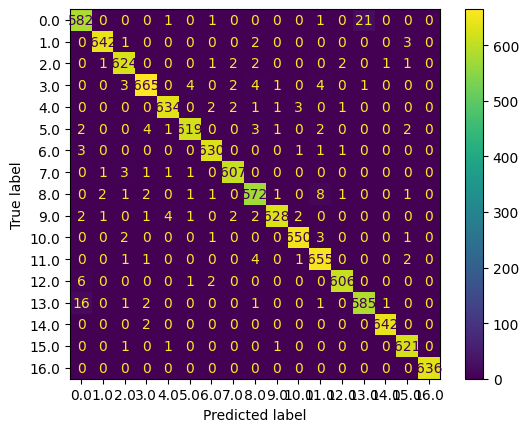

In [209]:
rf_matrix = metrics.confusion_matrix(y_val, predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=best_model.classes_)
disp.plot()

plt.show

#The lables are in float. Fixed when rerun the notebook, but has to retrain to fix that. Hope it is readable

In [221]:
predict_16 = best_model.predict(pca_X_val[y_val == 16])
metrics.accuracy_score(y_val[y_val==16], predict_16) 

1.0

100 percent accuracy on empty images

In [222]:
empties = pca.transform(np.zeros((2,400)))
empties_predict = best_model.predict(empties)
empties_predict

array([16., 16.])

In [223]:
wrongly_labled = np.nonzero(np.asarray(predictions != y_val))[0]

Showing some of the mislabled images

True 1 | Predict 8.0


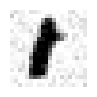

True 15 | Predict 4.0


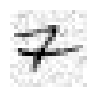

True 12 | Predict 0.0


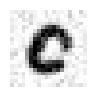

True 5 | Predict 11.0


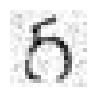

True 3 | Predict 5.0


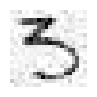

True 8 | Predict 3.0


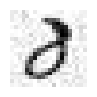

True 7 | Predict 2.0


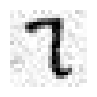

True 0 | Predict 13.0


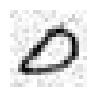

True 0 | Predict 13.0


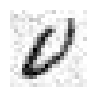

True 11 | Predict 15.0


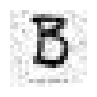

In [226]:
for ind in wrongly_labled[0:10]:
    print('True', y_val[ind], '|', 'Predict', predictions[ind])
    show_img(X_val[ind])

In [227]:

train_score = np.array(grid_search.cv_results_['mean_train_score'], dtype=np.float64)
test_score = np.array(grid_search.cv_results_['mean_test_score'], dtype=np.float64)
c = np.array(grid_search.cv_results_['param_C'], dtype=np.int64)
gamma = np.array(grid_search.cv_results_['param_gamma'], dtype=np.float64)
c
c_str = [f'C:{i}' for i in c]
gamma_str = [f'Gamma:{i:3f}' for i in gamma]

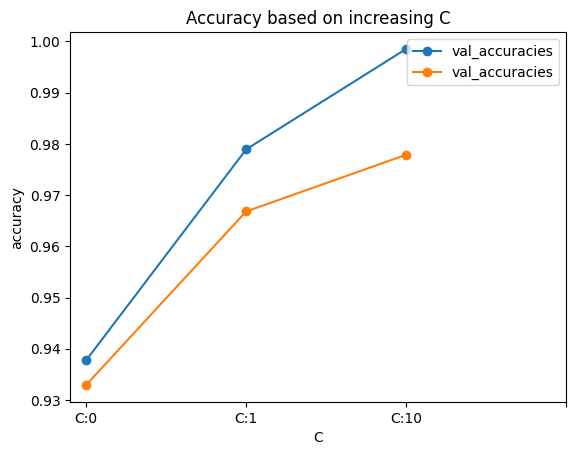

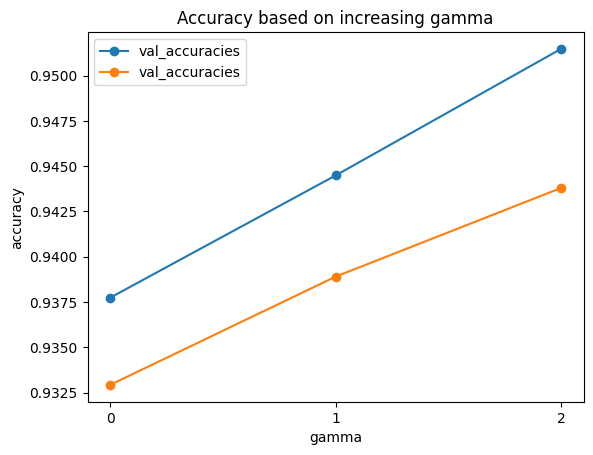

In [228]:


plt.plot(c_str[::3],train_score[::3], label='val_accuracies', marker='o')
plt.plot(c_str[::3],test_score[::3], label='val_accuracies', marker='o')

plt.xlabel('C')  
plt.ylabel('accuracy') 
  
# giving a title to my graph 
plt.title('Accuracy based on increasing C') 
plt.legend() 
plt.xticks(np.arange(0,4))


plt.show()
grid_search.cv_results_['params']

plt.plot(train_score[:3], label='val_accuracies', marker='o')
plt.plot(test_score[:3], label='val_accuracies', marker='o')

plt.xlabel('gamma')  
plt.ylabel('accuracy') 
  
# giving a title to my graph 
plt.title('Accuracy based on increasing gamma') 
plt.legend() 
plt.xticks(np.arange(0,3))


plt.show()

In [229]:
test_score[8], train_score[8]

(0.979196879498174, 0.9999420201624855)

In [285]:
svc_candidate = best_model

### How can we optimize more?

<b>Ensemble methods:</b>
- What is it?
  - A collection of smaller models, that predicts in a collective vote. The most common prediction is the final prediction.  

- Bagging
  - .
  - Pros
    - Faster training if done with multiprocessing, because of smaller training data.
    - Typically higher accuracy
  - Cons
    - Predicting takes longer
- Boosting
  -.

Wanted to do bagging with the best model to reduce overfitting, but I do not have time. And I think that it performs well enough already

### Testing with knn

In [231]:
knn = [1,3,5,7,11,15,21]
knn_models = []
knn_val_acc = []

knn_pca_models = []
knn_pca_val_acc = []

def train_val(X_train, y_train, X_val, y_val, model_list, acc_list):
    knn_clf = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    model_list.append(knn_clf)
    predictions = knn_clf.predict(X_val)
    acc_list.append(metrics.accuracy_score(y_val, predictions))

for k in knn:
    train_val(X_train, y_train, X_val, y_val, knn_models, knn_val_acc)
    train_val(pca_X_train, y_train, pca_X_val, y_val, knn_pca_models, knn_pca_val_acc)
    

In [239]:
best_model = knn_models[np.asarray(np.argmax(knn_val_acc))]
print(best_model)
predictions = best_model.predict(X_val)
print('Best model:', metrics.f1_score(y_val, predictions, average='macro'))

best_model_pca = knn_pca_models[np.asarray(np.argmax(knn_pca_val_acc))]
predictions = best_model_pca.predict(pca_X_val)
print('Best pca model:', metrics.f1_score(y_val, predictions, average='macro'))

KNeighborsClassifier(n_neighbors=1)
Best model: 0.9638881411341478
Best pca model: 0.9685054361561373


Looks like smaller k are the best

In [279]:
bagged_knn = ensemble.BaggingClassifier(best_model, n_estimators=100).fit(pca_X_train, y_train)

In [280]:
predictions = bagged_knn.predict(pca_X_val)
print('Best pca model:', metrics.f1_score(y_val, predictions, average='macro'))

Best pca model: 0.9685054361561373


<function matplotlib.pyplot.show(close=None, block=None)>

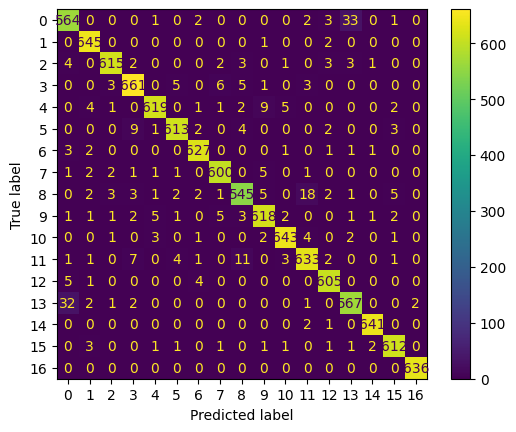

In [281]:
cf_matrix = metrics.confusion_matrix(y_val, predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=bagged_knn.classes_)
disp.plot()

plt.show

In [282]:
knn_candidate = bagged_knn

## Testing with decision trees

First testing boosing with gradient boosted machine, then bagging with random forest

### Testing with gradient boosted machine

I will use sklearn's implementation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
It is stated in the implementation that it is better to use another version called HistGradientBoostingClassifier, when dealing with number of samples over 10000, which we do. 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier

This is a boosting ensemble method. It should in theory reduce bias, and variance in supervised learning. It uses a hierarchy decision trees. Where the lower levels helps with weaknesses of the above.\
\
It uses the loss function log-los to determine which tree to keep for each iteration. The learning rate/shrinkage is 0.1 per default. The default number of iterations is 100, and I think that should be enough.


In [253]:
classic_tree = DecisionTreeClassifier()
classic_tree.fit(X_train, y_train)

tree_predict = classic_tree.predict(X_val)

In [254]:
metrics.f1_score(y_val, tree_predict, average='macro')

0.8406414018416858

In [260]:
gb_clf_pca = ensemble.HistGradientBoostingClassifier(verbose=2).fit(pca_X_train, y_train)

Binning 0.031 GB of training data: 0.432 s
Binning 0.003 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
[1/100] 17 trees, 506 leaves (29 on avg), max depth = 10, train loss: 1.97773, val loss: 2.01109, in 0.156s
[2/100] 17 trees, 527 leaves (31 on avg), max depth = 11, train loss: 1.67274, val loss: 1.71644, in 0.166s
[3/100] 17 trees, 527 leaves (31 on avg), max depth = 13, train loss: 1.46004, val loss: 1.51351, in 0.165s
[4/100] 17 trees, 527 leaves (31 on avg), max depth = 12, train loss: 1.29766, val loss: 1.35983, in 0.192s
[5/100] 17 trees, 527 leaves (31 on avg), max depth = 11, train loss: 1.16584, val loss: 1.23456, in 0.176s
[6/100] 17 trees, 527 leaves (31 on avg), max depth = 12, train loss: 1.05740, val loss: 1.13134, in 0.179s
[7/100] 17 trees, 527 leaves (31 on avg), max depth = 11, train loss: 0.96369, val loss: 1.04390, in 0.176s
[8/100] 17 trees, 527 leaves (31 on avg), max depth = 11, train loss: 0.88436, val loss: 0.96835, in 0.176s
[9/100] 17 tree

[75/100] 17 trees, 527 leaves (31 on avg), max depth = 15, train loss: 0.05293, val loss: 0.18721, in 0.204s
[76/100] 17 trees, 527 leaves (31 on avg), max depth = 14, train loss: 0.05136, val loss: 0.18575, in 0.212s
[77/100] 17 trees, 527 leaves (31 on avg), max depth = 14, train loss: 0.04981, val loss: 0.18411, in 0.212s
[78/100] 17 trees, 527 leaves (31 on avg), max depth = 15, train loss: 0.04830, val loss: 0.18247, in 0.175s
[79/100] 17 trees, 527 leaves (31 on avg), max depth = 14, train loss: 0.04686, val loss: 0.18082, in 0.177s
[80/100] 17 trees, 527 leaves (31 on avg), max depth = 15, train loss: 0.04551, val loss: 0.17954, in 0.190s
[81/100] 17 trees, 527 leaves (31 on avg), max depth = 16, train loss: 0.04417, val loss: 0.17818, in 0.185s
[82/100] 17 trees, 527 leaves (31 on avg), max depth = 14, train loss: 0.04294, val loss: 0.17695, in 0.183s
[83/100] 17 trees, 527 leaves (31 on avg), max depth = 15, train loss: 0.04171, val loss: 0.17575, in 0.198s
[84/100] 17 trees, 

In [261]:
pca_gb_predict = gb_clf_pca.predict(pca_X_val)
pca_gb_predict_train = gb_clf_pca.predict(pca_X_train)
print('Training accuracy:', metrics.accuracy_score(y_train, pca_gb_predict_train))
metrics.f1_score(y_val, pca_gb_predict, average='macro')

Training accuracy: 0.995408003525169


0.958324127420558

Better results with gradient boost

In [262]:
gb_clf_pca = ensemble.HistGradientBoostingClassifier(max_iter=500, verbose=2).fit(pca_X_train, y_train)

Binning 0.031 GB of training data: 0.421 s
Binning 0.003 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
[1/500] 17 trees, 510 leaves (30 on avg), max depth = 10, train loss: 1.97570, val loss: 2.00462, in 0.165s
[2/500] 17 trees, 527 leaves (31 on avg), max depth = 11, train loss: 1.67060, val loss: 1.71329, in 0.161s
[3/500] 17 trees, 527 leaves (31 on avg), max depth = 11, train loss: 1.45823, val loss: 1.50901, in 0.161s
[4/500] 17 trees, 527 leaves (31 on avg), max depth = 12, train loss: 1.29610, val loss: 1.35173, in 0.172s
[5/500] 17 trees, 527 leaves (31 on avg), max depth = 12, train loss: 1.16636, val loss: 1.22816, in 0.169s
[6/500] 17 trees, 527 leaves (31 on avg), max depth = 12, train loss: 1.05585, val loss: 1.12381, in 0.167s
[7/500] 17 trees, 527 leaves (31 on avg), max depth = 11, train loss: 0.96352, val loss: 1.03639, in 0.174s
[8/500] 17 trees, 527 leaves (31 on avg), max depth = 11, train loss: 0.88342, val loss: 0.96008, in 0.175s
[9/500] 17 tree

[76/500] 17 trees, 527 leaves (31 on avg), max depth = 15, train loss: 0.05145, val loss: 0.18522, in 0.207s
[77/500] 17 trees, 527 leaves (31 on avg), max depth = 15, train loss: 0.04990, val loss: 0.18360, in 0.200s
[78/500] 17 trees, 527 leaves (31 on avg), max depth = 17, train loss: 0.04840, val loss: 0.18208, in 0.180s
[79/500] 17 trees, 527 leaves (31 on avg), max depth = 17, train loss: 0.04692, val loss: 0.18064, in 0.181s
[80/500] 17 trees, 527 leaves (31 on avg), max depth = 13, train loss: 0.04558, val loss: 0.17928, in 0.174s
[81/500] 17 trees, 527 leaves (31 on avg), max depth = 14, train loss: 0.04425, val loss: 0.17778, in 0.183s
[82/500] 17 trees, 527 leaves (31 on avg), max depth = 16, train loss: 0.04298, val loss: 0.17648, in 0.205s
[83/500] 17 trees, 527 leaves (31 on avg), max depth = 17, train loss: 0.04172, val loss: 0.17497, in 0.231s
[84/500] 17 trees, 527 leaves (31 on avg), max depth = 20, train loss: 0.04051, val loss: 0.17378, in 0.223s
[85/500] 17 trees, 

[151/500] 17 trees, 497 leaves (29 on avg), max depth = 15, train loss: 0.00669, val loss: 0.13416, in 0.173s
[152/500] 17 trees, 497 leaves (29 on avg), max depth = 15, train loss: 0.00653, val loss: 0.13393, in 0.180s
[153/500] 17 trees, 497 leaves (29 on avg), max depth = 16, train loss: 0.00637, val loss: 0.13356, in 0.174s
[154/500] 17 trees, 497 leaves (29 on avg), max depth = 14, train loss: 0.00621, val loss: 0.13311, in 0.178s
[155/500] 17 trees, 497 leaves (29 on avg), max depth = 16, train loss: 0.00607, val loss: 0.13300, in 0.175s
[156/500] 17 trees, 497 leaves (29 on avg), max depth = 13, train loss: 0.00591, val loss: 0.13281, in 0.173s
[157/500] 17 trees, 497 leaves (29 on avg), max depth = 15, train loss: 0.00577, val loss: 0.13267, in 0.173s
[158/500] 17 trees, 497 leaves (29 on avg), max depth = 12, train loss: 0.00562, val loss: 0.13249, in 0.177s
[159/500] 17 trees, 497 leaves (29 on avg), max depth = 14, train loss: 0.00549, val loss: 0.13229, in 0.178s
[160/500] 

In [263]:
pca_gb_predict_val = gb_clf_pca.predict(pca_X_val)
pca_gb_predict_train = gb_clf_pca.predict(pca_X_train)
print('Training accuracy:', metrics.accuracy_score(y_train, pca_gb_predict_train))
print('Validation accuracy:', metrics.accuracy_score(y_val, pca_gb_predict_val))


Training accuracy: 0.9961965281723623
Validation accuracy: 0.9676252319109462


Based on results we can get the best validation accuracy with pca data with 262 iterations. Since it takes faster I will use pca data with default learning rate to do cross validation. I aknowledge the fact that there could exist a better model with tuning on non pca data, but I do not have the time to test that. 

In [288]:
parameters = [{'max_iter': [50, 100, 150], 'min_samples_leaf': [10,20,30]}]

default_SVC_clf = ensemble.HistGradientBoostingClassifier(max_iter=50)
    
#Using grid search to test the different parameters, to train different classifiers for all combinations of gamma and c. 3*3 = 9.
grid_search_gb = GridSearchCV(default_SVC_clf, parameters, cv=3, verbose=2, return_train_score=True)

grid_search_gb.fit(pca_X_train, y_train)

In [289]:
grid_search_gb.best_params_

Forgot to save the grid search and I do not have time to let it run again. Hence it will get the best model if the notebook is restarted.

In [290]:
grid_search_gb.best_estimator_

In [293]:
predictions = grid_search_gb.best_estimator_.predict(pca_X_train)
print('Train accuracy:', metrics.accuracy_score(y_train, predictions))
predictions = grid_search_gb.best_estimator_.predict(pca_X_val)
print('Validation accuracy:', metrics.accuracy_score(y_val, predictions))
rf_matrix = metrics.confusion_matrix(y_val, predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=grid_search_gb.classes_)
disp.plot()

gb_candidate = grid_search_gb.best_estimator_

In [ ]:
#Remove the cell under if restarting notebook.

Train accuracy: 0.9966023864466528
Validation accuracy: 0.9637291280148423


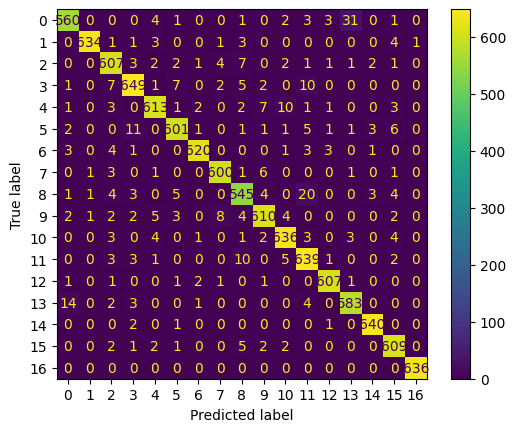

In [292]:
gb_candidate = ensemble.HistGradientBoostingClassifier(max_iter=150, min_samples_leaf=20).fit(pca_X_train, y_train)
predictions = gb_candidate.predict(pca_X_train)
print('Train accuracy:', metrics.accuracy_score(y_train, predictions))
predictions = gb_candidate.predict(pca_X_val)
print('Validation accuracy:', metrics.accuracy_score(y_val, predictions))
rf_matrix = metrics.confusion_matrix(y_val, predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=gb_candidate.classes_)
disp.plot()

Increasing min leaf samples make the tree

We can see that the default model with the full dimensional data performed better than optimized model trained with reduced data. However the default model took 148.343 s to train, whilst the optimized model took 27.8s. 

### Testing random forest

In [265]:
#Training a random forest classifier
start = time.time()
rf_clf = ensemble.RandomForestClassifier(max_features=None,n_estimators=100,min_samples_leaf=20, random_state=seed).fit(X_train, y_train)
predictions = rf_clf.predict(X_train)
print('Train accuracy:', metrics.accuracy_score(y_train, predictions))
predictions = rf_clf.predict(X_val)
print('Validation accuracy:', metrics.f1_score(y_val, predictions, average='macro'))
end = time.time()

print('Time spent:', end-start)

Train accuracy: 0.955935387362733
Validation accuracy: 0.9205497888007179
Time spent: 95.75768423080444


In [266]:
#Training a random forest classifier with pca data, so min samples per leaf can be lower. 
#If min samples per leaf becomes low, then it becomes more overfitted.
start = time.time()
rf_clf = ensemble.RandomForestClassifier(max_features='sqrt', n_estimators=300,min_samples_leaf=20, random_state=seed).fit(pca_X_train, y_train)
predictions = rf_clf.predict(pca_X_train)
print('Train accuracy:', metrics.accuracy_score(y_train, predictions))
predictions = rf_clf.predict(pca_X_val)
print('Validation accuracy:', metrics.accuracy_score(y_val, predictions))
end = time.time()

print('Time spent:', end-start)

Train accuracy: 0.9652237438686411
Validation accuracy: 0.9336734693877551
Time spent: 6.499310255050659


Small test observations. Pca data performs worse. Max_features=None gives worse, max_Features='sqrt' or 'log2' gives similar. n_estimators generally increase accuracy. min_samples_leaf gives higher accuracy with lower value, but also increase training accuracy. 

In [267]:
#Tuning hyperparameters. With small testing, n_estimators, min_samples_leaf and 

In [268]:
parameters = [{'n_estimators': [50, 100, 150], 'min_samples_leaf': [10,20,30]}]

default_rf_clf = ensemble.RandomForestClassifier(random_state=seed)
    
#Using grid search to test the different parameters, to train different classifiers for all combinations of gamma and c. 3*3 = 9.
grid_search_rf = GridSearchCV(default_rf_clf, parameters, cv=3, verbose=2, return_train_score=True)

grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ...............min_samples_leaf=10, n_estimators=50; total time=   2.2s
[CV] END ...............min_samples_leaf=10, n_estimators=50; total time=   2.2s
[CV] END ...............min_samples_leaf=10, n_estimators=50; total time=   2.2s
[CV] END ..............min_samples_leaf=10, n_estimators=100; total time=   4.0s
[CV] END ..............min_samples_leaf=10, n_estimators=100; total time=   4.0s
[CV] END ..............min_samples_leaf=10, n_estimators=100; total time=   4.0s
[CV] END ..............min_samples_leaf=10, n_estimators=150; total time=   6.1s
[CV] END ..............min_samples_leaf=10, n_estimators=150; total time=   5.9s
[CV] END ..............min_samples_leaf=10, n_estimators=150; total time=   6.1s
[CV] END ...............min_samples_leaf=20, n_estimators=50; total time=   2.2s
[CV] END ...............min_samples_leaf=20, n_estimators=50; total time=   1.9s
[CV] END ...............min_samples_leaf=20, n_es

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'min_samples_leaf': [10, 20, 30],
                          'n_estimators': [50, 100, 150]}],
             return_train_score=True, verbose=2)

In [269]:
grid_search_rf.best_params_

{'min_samples_leaf': 10, 'n_estimators': 150}

Validation accuracy: 0.9525974025974026


<function matplotlib.pyplot.show(close=None, block=None)>

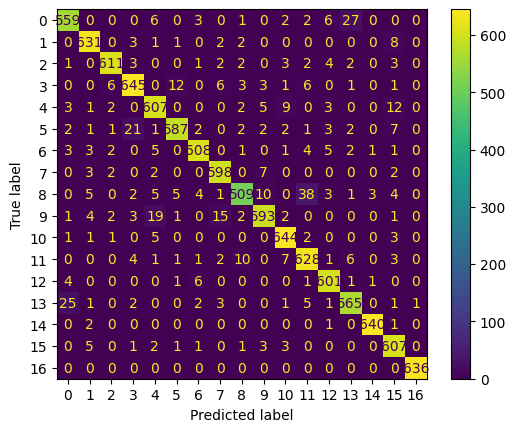

In [270]:
predictions = grid_search_rf.best_estimator_.predict(X_val)
print('Validation accuracy:', metrics.accuracy_score(y_val, predictions))
rf_matrix = metrics.confusion_matrix(y_val, predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=Loaded_rf_model.classes_)
disp.plot()

plt.show

In [276]:
rf_candidate = grid_search_rf.best_estimator_

## Testing convolutional neural network

A neural network is built by hidden layers of neurons and activation functions. It is fed data, and makes a classification based on its trained weights. The convolutional neural networks has some extra properties, where it does feature extraction before classification. It takes a kernel/filter and does convolution to find edges / relevant features, then it pools/subsamples into smaller subsets and repeats it until it reaches a specific size. Then it feeds the feature maps to the localy connected network for classification.

Important parameters for feature extraction is of course the kernel, and the stride lenght. Stride lenght is how many pixels you move. Our kernel will be focused on outline detection to find the contour of the image. The pooling reduces the feature maps with downsampling/subsample. Different types of pooling is average or max. 

Used Codemy.com series to get a better understanding for convolutional neural netorks. \
https://www.youtube.com/watch?v=kY14KfZQ1TI&list=PLCC34OHNcOtpcgR9LEYSdi9r7XIbpkpK1
Code examples have been modified to work with our data, and hypertuning has been done on own accord and experiments. So the code is inspired but not pasted. 


In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid


In [62]:
torch.cuda.is_available()

True

In [63]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 3070 Ti'

My gpu has 8gb of vram. Based on the size of the data, It is more than enough. 

In [64]:
cuda_device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")



In [65]:
torch.cuda.memory_allocated(device=0)

0

For the data to work with a cnn, we need to convert it to a tensor.

In [66]:
transform = transforms.ToTensor()

It took some time to figure out how to properly convert the data to workable tensors, but eventually it worked out.

In [67]:
#For the data to work properly I found that you need to put X and Y together in a tensorDataset. Then you can create a loader.

#First prep the tensors to the right shape, and enable gpu acceleration
X_train_tensor = X_train.reshape(-1,1,20,20)
X_train_tensor = torch.Tensor(X_train_tensor).to(cuda_device)


y_train_tensor = y_train.reshape(y_train.shape[0])
y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long).to(cuda_device)

#Merge the tensors to a dataset, and create a dataloader.
X_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(X_train_dataset, batch_size=32)

In [68]:
#Repeat for val and test

#First prep the tensors to the right shape, and enable gpu acceleration
X_val_tensor = X_val.reshape(-1,1,20,20)
X_val_tensor = torch.Tensor(X_val_tensor).to(cuda_device)

y_val_tensor = y_val.reshape(y_val.shape[0])
y_val_tensor = torch.tensor(y_val_tensor, dtype=torch.long).to(cuda_device)

#Merge the tensors to a dataset, and create a dataloader.
X_val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(X_val_dataset, batch_size=len(y_val))


#test set
X_test_tensor = X_test.reshape(-1,1,20,20)
X_test_tensor = torch.Tensor(X_test_tensor).to(cuda_device)

y_test_tensor = y_test.reshape(y_test.shape[0])
y_test_tensor = torch.tensor(y_test_tensor, dtype=torch.long).to(cuda_device)

#creating test loader
X_test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(X_test_dataset, batch_size=len(y_test))

In [69]:
stop = 0
for i, a in enumerate(train_loader):
    print(a[1])
    stop+=1
    if stop == 10:
        break

tensor([10, 13, 16,  3, 11,  2, 15, 13, 13,  3, 11,  6,  6, 13,  6,  1,  9, 15,
        11, 13, 16,  0, 13,  8,  8, 15,  7,  6,  4,  4,  2,  9],
       device='cuda:0')
tensor([ 2,  0,  8,  0,  8,  1, 15,  1, 13, 16,  3,  8,  4,  8, 14, 11,  7, 10,
        16,  3,  0,  9,  0, 10,  2,  7,  2, 16, 16,  2,  9,  5],
       device='cuda:0')
tensor([ 2,  0,  8,  4,  7, 13,  8, 14, 16, 15, 11, 13, 16, 10, 11, 13, 11, 10,
        14, 12,  5, 11,  5,  6, 11, 14,  9, 10,  5,  8,  0,  6],
       device='cuda:0')
tensor([ 5,  6, 10, 12,  9, 11,  8,  2, 14, 11,  9, 12,  0, 15, 13,  4, 10,  6,
        10,  3,  3, 13, 14,  0, 11,  5,  6,  3,  6,  5, 11,  0],
       device='cuda:0')
tensor([12, 15,  8,  3, 14,  8,  7, 11,  8,  4,  2,  6,  4,  6, 15,  2,  2, 14,
         4,  8,  9,  6,  5,  7,  5,  5,  8,  0,  0, 10,  8, 10],
       device='cuda:0')
tensor([ 2,  5, 16,  8, 16,  5, 16,  2,  9,  5, 16,  6,  1,  7,  1, 11,  0,  4,
         8,  6, 13,  8,  1,  5, 13, 11,  5,  9, 15,  8,  1,  5],
       dev

Need to create a loader, to split into smaller batches

Now time to define the CNN model\
\
input layers, output layers, kernel size, stride are the important arguments. Padding is also a parameter, when off it shrinks the image. When we did our test of relevant pixels earlier, we saw that the outer pixels had little impact, so the shrinking is actually good for this use case

Before that I am going to show the feature extracting part with an example.

In [70]:
conv1 = nn.Conv2d(1,8,2,1).to(cuda_device)
#Inputs are now the outputs of conv1
conv2 = nn.Conv2d(8,24,2,1).to(cuda_device)

In [71]:
X_train_t, y_train_t = next(iter(X_train_dataset))

In [72]:
X_train_t.shape, y_train_t.shape

(torch.Size([1, 20, 20]), torch.Size([]))

In [73]:
test_x = X_train_tensor[0].view(1,20,20)
test_x.shape

torch.Size([1, 20, 20])

In [74]:
x = F.relu(conv1(test_x))
x.shape

torch.Size([8, 19, 19])

In [75]:
#Now pooling with a kernel size of 2, stride 2, and keeping the max values.
x = F.max_pool2d(x, 2,2).to(cuda_device)
x.shape

torch.Size([8, 9, 9])

In [76]:
x = F.relu(conv2(x))

In [77]:
x.shape

torch.Size([24, 8, 8])

In [78]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([24, 4, 4])

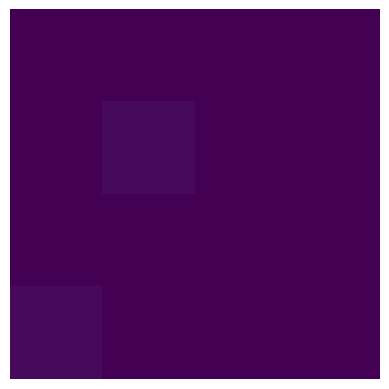

In [79]:
feature_map_0 = x[1].cpu().detach().numpy()
plt.imshow(feature_map_0, vmin=0, vmax=255)
plt.axis('off')
plt.show()

Now making the model

In [80]:
#Starting with creationg a model class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        #Initialize the neural network class attributes
        super().__init__()
        
        #Create the convolutions
        self.conv1 = nn.Conv2d(1,8,2,1).to(cuda_device)
        self.conv2 = nn.Conv2d(8,24,2,1).to(cuda_device)
        
        #Create fully connected layers for classification
        self.fc1 = nn.Linear(24*4*4, 120).to(cuda_device)
        self.fc2 = nn.Linear(120, 80).to(cuda_device)
        self.fc3 = nn.Linear(80, len(np.unique(y))).to(cuda_device)
    
    
    #Push forward function, with relu as activation funciton. Either positive or 0
    def forward(self, X):
        #First pass
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2,2)
        #Second pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2,2)
        
        #Need to Re-View data to flatten
        X = X.view(-1, 4*4*24)
        #-1 so the batchsize can be varied
        
        #Fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [81]:
#Create the model
torch.manual_seed(42)
cnn_model = ConvolutionalNetwork().cuda()
cnn_model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(8, 24, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=384, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=17, bias=True)
)

In [82]:
for i in cnn_model.parameters():
    print(i.is_cuda)

True
True
True
True
True
True
True
True
True
True


In [83]:
def test_cnn(model, loader):
    criterion = nn.CrossEntropyLoss()
    test_corr = 0
    #Test
    with torch.no_grad(): #No gradient so we dont update the model with out val data
        for b, (X_test_t, y_test_t) in enumerate(val_loader):
            y_test_pred = model(X_test_t)
            predicted = torch.max(y_test_pred.data,1)[1] #Adding correct predictions
            test_corr += (predicted == y_test_t).sum() 
            
    loss = criterion(y_test_pred, y_test_t)
    
    return loss, test_corr


In [84]:
def train_cnn(model, epochs=5, lr=0.001):

    #Loss function optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) #Smaller learning rate takes longer

    #Start timing
    start = time.time()

    #Create Variables to track
    #How many times to train
    epochs = epochs
    train_losses = []
    train_correct = []
    val_losses = []
    val_correct = []

    #For loop of Epochs
    for i in range(epochs):
        train_corr = 0

        #Train
        for b, (X_train_t, y_train_t) in enumerate(train_loader):

            b += 1 #Start batches at 1

            y_pred = model(X_train_t) #Get the predicted values from the training set.
            loss = criterion(y_pred, y_train_t) #How wrong were the prediction

            predicted = torch.max(y_pred.data, 1)[1] #add up number of correct predictions. Indexed of 1st item
            batch_corr = (predicted == y_train_t).sum() # How many correct from this batch
            train_corr += batch_corr #Overall training correct as we train

            #Updata parameters to get better
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            #print some results
            if b%1000 == 0:
                print(f'Epoch: {i}, Batch {b}, Loss:{loss.item()}')


        train_losses.append(loss)
        train_correct.append(train_corr)
        
        #Test model
        val_loss, val_corr = test_cnn(model, val_loader)
        val_losses.append(val_loss)
        val_correct.append(val_corr)
    
    end = time.time()
    total_time = end-start
    print('Training time in min:', total_time/60)
    
    return model, (train_losses, train_correct), (val_losses, val_correct)


    

In [85]:
cnn_model, (train_losses, train_correct), (val_losses, val_correct) = train_cnn(cnn_model, epochs=8)

Epoch: 0, Batch 1000, Loss:0.3117348551750183
Epoch: 0, Batch 2000, Loss:0.22383424639701843
Epoch: 1, Batch 1000, Loss:0.10848583281040192
Epoch: 1, Batch 2000, Loss:0.2098313719034195
Epoch: 2, Batch 1000, Loss:0.06699185073375702
Epoch: 2, Batch 2000, Loss:0.05063636600971222
Epoch: 3, Batch 1000, Loss:0.09937701374292374
Epoch: 3, Batch 2000, Loss:0.02892370894551277
Epoch: 4, Batch 1000, Loss:0.10036341845989227
Epoch: 4, Batch 2000, Loss:0.038388580083847046
Epoch: 5, Batch 1000, Loss:0.017717035487294197
Epoch: 5, Batch 2000, Loss:0.03259566053748131
Epoch: 6, Batch 1000, Loss:0.004390104673802853
Epoch: 6, Batch 2000, Loss:0.014221038669347763
Epoch: 7, Batch 1000, Loss:0.0103389797732234
Epoch: 7, Batch 2000, Loss:0.10568982362747192
Training time in min: 0.7711158394813538


<function matplotlib.pyplot.show(close=None, block=None)>

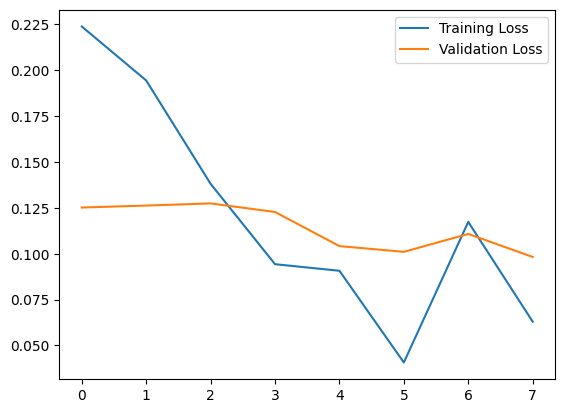

In [86]:
plt.plot([tl.cpu().detach().numpy() for tl in train_losses], label='Training Loss')
plt.plot([tl.cpu().detach().numpy() for tl in val_losses], label='Validation Loss')
plt.legend()
plt.show



0.9769944341372913

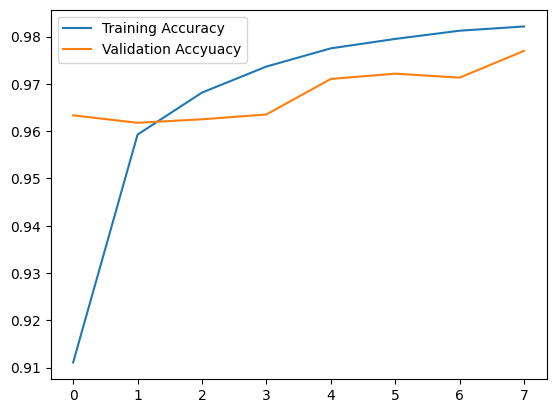

In [87]:
plt.plot([tl.cpu().detach().numpy()/len(X_train) for tl in train_correct], label='Training Accuracy')
plt.plot([tl.cpu().detach().numpy()/len(X_val) for tl in val_correct], label='Validation Accyuacy')
plt.legend()
plt.show

max([tl.cpu().detach().numpy()/len(X_val) for tl in val_correct])

In [93]:
val_correct[-1].cpu().detach().numpy()/len(X_val)

0.9769944341372913

#### Comparing the models with validation accuracy, and choosing the best

In [303]:
candidates_pca = [svc_candidate, knn_candidate, gb_candidate]
candidates_non = [rf_candidate]


best_model = None
best_f1 = 0

#The model that has the highest f1 score on validation data is the best. 
for model in candidates_pca:
    preds = model.predict(pca_X_val)
    f1 = metrics.f1_score(y_val, preds, average='macro')
    if f1 > best_f1:
        best_model = model
        best_f1 = f1

#For the models that just uses X_train
for model in candidates_pca:
    preds = model.predict(pca_X_val)
    f1 = metrics.f1_score(y_val, preds, average='macro')
    if f1 > best_f1:
        best_model = model
        best_f1 = f1

    

In [305]:
best_model, best_f1

(SVC(C=10, gamma=1.167406797335413e-06), 0.9829701034740478)

Testing on unseen data

In [310]:
#If the best model uses pca data
if best_model.n_features_in_ == 50:
    predictions = best_model.predict(pca_X_test)
else:
    predictions = best_model.predict(pca_X_test)
    

In [315]:
#Finding the f1 score and accuracy
print('f1:',metrics.f1_score(y_test, predictions, average='macro'))
print('Accuracy:', metrics.accuracy_score(y_test, predictions))

f1: 0.982164012354946
Accuracy: 0.9820037105751391


<function matplotlib.pyplot.show(close=None, block=None)>

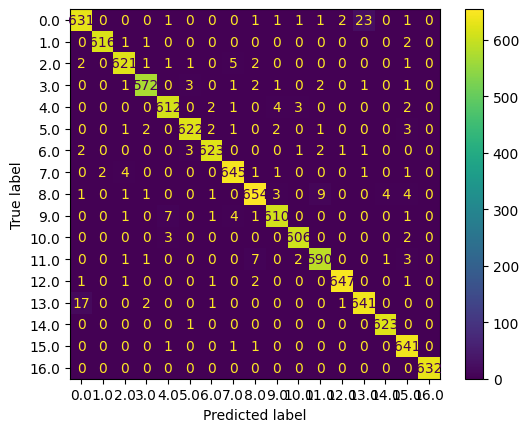

In [316]:
rf_matrix = metrics.confusion_matrix(y_test, predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=best_model.classes_)
disp.plot()

plt.show

looks very good on unseen data

Most mishaps on 0 and small E